In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import math
import seaborn as sns
from IPython.core.display import display, HTML
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

In [25]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'speilberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095'}

In [23]:
dirs_page = dirs['hitchock']
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

{'fassbinder': 'https://www.imdb.com/name/nm0001202/',
 'godard': 'https://www.imdb.com/name/nm0000419/',
 'hitchcock': 'https://www.imdb.com/name/nm0000033'}

In [3]:

#url = 'https://www.boxofficemojo.com/title/tt0118715/' 
#url = 'https://www.imdb.com/name/nm0001202?ref_=nv_sr_srsg_0'
fassbinder_page = 'https://www.imdb.com/name/nm0001202/'
godard_page = 'https://www.imdb.com/name/nm0000419/?ref_=nv_sr_srsg_0'
hitchcock_page = 'https://www.imdb.com/name/nm0000033'
speilberg_page = 'https://www.imdb.com/name/nm0000229'
kurosawa_page = 'https://www.imdb.com/name/nm0000041/'
bergman_page = 'https://www.imdb.com/name/nm0000005/'
allen_page = 'https://www.imdb.com/name/nm0000095'
director_page = hitchcock_page
url = director_page
response = requests.get(url)
soup = BeautifulSoup(page, "lxml")
films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [11]:
def is_TV_Series( the_film_soup ):  
    try:
        check_text = the_film_soup.find('a', title='See more release dates' )
        if check_text is not None:
            if( check_text==re.compile('TV Series')): 
                print("It's a TV series")
                return True
        else:
            return False
    except:
        return False
    

In [12]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    except:
        film_title_string = ''
    #title_line = film_title_string.strip(')').split(' (')    
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0] # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '') if len(title_line) > 1 else '' # year part of title line
 
    if ( is_TV_Series( film_soup) ):
        film_is_TV_series = True
    else:
        film_is_TV_series = False
    film_data['tv_series'] = film_is_TV_series
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        #print(film_duration_string.replace('min',''))
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
        
 
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [13]:
list_of_films = []

for film in films:
    film_url_suffix = film.find('a').get('href')
    film_url = 'https://imdb.com' + film_url_suffix
    print('\n', film_url)
    film_response = requests.get(film_url)
    if(film_response.status_code < 400):
        film_page = film_response.text
        film_soup = BeautifulSoup(film_page, "lxml")
 #   if ( not is_TV_Series( film_soup) ):
        film = parse_film_data( film_soup )
        print(film)
        list_of_films.append(film)
        
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt6914094/
{'title': 'Kaleidoscope', 'year': '1967', 'tv_series': False, 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': None, 'budget': None}

 https://imdb.com/title/tt3455796/
{'title': 'Memory of the Camps', 'year': '2014', 'tv_series': False, 'rating': '8.3', 'rating_count': 480.0, 'duration': 70, 'release_date': ' 26 July 2015 (USA)    ', 'metacritic_score': None, 'worldwide_gross': 4468, 'runtime': 70, 'budget': None}

 https://imdb.com/title/tt0074512/
{'title': 'Family Plot', 'year': '1976', 'tv_series': False, 'rating': '6.8', 'rating_count': 20752.0, 'duration': None, 'release_date': ' 9 April 1976 (USA)    ', 'metacritic_score': '79', 'worldwide_gross': None, 'runtime': 120, 'budget': 4490375}

 https://imdb.com/title/tt0068611/
{'title': 'Frenzy', 'year': '1972', 'tv_series': False, 'rating': '7.4', 'rating_count': 41382.0, 'duration': 116, 'release_date': ' 2

{'title': 'Watchtower Over Tomorrow', 'year': '1945', 'tv_series': False, 'rating': '6.5', 'rating_count': 213.0, 'duration': 15, 'release_date': ' 29 March 1945 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 15, 'budget': None}

 https://imdb.com/title/tt1375299/
{'title': 'The Fighting Generation', 'year': '1944', 'tv_series': False, 'rating': '5.9', 'rating_count': 213.0, 'duration': 2, 'release_date': ' October 1944 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 2, 'budget': None}

 https://imdb.com/title/tt0036621/
{'title': 'Aventure malgache', 'year': '1944', 'tv_series': False, 'rating': '5.5', 'rating_count': 1446.0, 'duration': 32, 'release_date': ' June 1944 (Portugal)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 32, 'budget': None}

 https://imdb.com/title/tt0036659/
{'title': 'Bon Voyage', 'year': '1944', 'tv_series': False, 'rating': '6.2', 'rating_count': 1651.0, 'duration': 26, 'release_date': 

{'title': 'Sound Test for Blackmail', 'year': '1929', 'tv_series': False, 'rating': '7.1', 'rating_count': 543.0, 'duration': 1, 'release_date': '', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 1, 'budget': None}

 https://imdb.com/title/tt0019702/
{'title': 'Blackmail', 'year': '1929', 'tv_series': False, 'rating': '7.0', 'rating_count': 9615.0, 'duration': 85, 'release_date': ' 6 October 1929 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 85, 'budget': None}

 https://imdb.com/title/tt0020142/
{'title': 'The Manxman', 'year': '1929', 'tv_series': False, 'rating': '6.2', 'rating_count': 2597.0, 'duration': 110, 'release_date': ' 16 December 1929 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 110, 'budget': None}

 https://imdb.com/title/tt0018756/
{'title': 'Champagne', 'year': '1928', 'tv_series': False, 'rating': '5.6', 'rating_count': 2018.0, 'duration': 86, 'release_date': ' 20 August 1928 (UK)    ', 'metacriti

In [94]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross'] = pd.to_numeric(film_catalog['worldwide_gross'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])
film_catalog.drop('tv_series',1, inplace=True)

In [17]:
film_catalog.shape

(85, 11)

In [18]:
film_catalog.head(50)

,title,year,tv_series,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross,runtime,budget
0,Kaleidoscope,1967,False,None,NaN,NaN,,None,NaN,NaN,NaN
1,Memory of the Camps,2014,False,8.3,480.0,70.0,26 July 2015 (USA),None,4468.0,70.0,NaN
2,Family Plot,1976,False,6.8,20752.0,NaN,9 April 1976 (USA),79,NaN,120.0,4490375.0
3,Frenzy,1972,False,7.4,41382.0,116.0,21 June 1972 (USA),92,4121.0,116.0,2000000.0
4,Topaz,1969,False,6.3,16698.0,143.0,19 December 1969 (USA),None,NaN,143.0,4000000.0
5,Torn Curtain,1966,False,6.7,24706.0,128.0,27 July 1966 (USA),55,NaN,128.0,6000000.0
6,Marnie,1964,False,7.2,45171.0,130.0,17 July 1964 (USA),73,7095.0,130.0,3000000.0
7,The Birds,1963,False,7.7,171368.0,119.0,29 March 1963 (USA),90,32655.0,119.0,2500000.0
8,The Alfred Hitchcock Hour,,False,8.5,3875.0,50.0,20 September 1962 (USA),None,NaN,50.0,NaN
9,Alfred Hitchcock Presents,,False,8.5,14749.0,25.0,2 October 1955 (USA),None,NaN,25.0,NaN


In [20]:
film_catalog.tail(35)

,title,year,tv_series,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross,runtime,budget
50,Number 17,1932,False,5.8,4420.0,66.0,7 November 1932 (UK),None,NaN,66.0,NaN
51,East of Shanghai,1931,False,5.8,3967.0,83.0,13 June 1932 (UK),None,NaN,110.0,NaN
52,Mary,1931,False,6.1,678.0,78.0,2 March 1931 (Germany),None,NaN,78.0,NaN
53,The Skin Game,1931,False,5.8,2869.0,85.0,20 June 1931 (USA),None,NaN,85.0,NaN
54,Murder!,1930,False,6.4,5771.0,92.0,24 November 1930 (USA),None,NaN,104.0,NaN
55,Juno and the Paycock,1930,False,4.8,2062.0,85.0,22 September 1930 (UK),None,NaN,85.0,NaN
56,An Elastic Affair,1930,False,6.9,98.0,10.0,February 1930 (UK),None,NaN,10.0,NaN
57,Elstree Calling,1930,False,5.3,344.0,86.0,29 September 1930 (UK),None,NaN,86.0,NaN
58,Sound Test for Blackmail,1929,False,7.1,543.0,1.0,,None,NaN,1.0,NaN
59,Blackmail,1929,False,7.0,9615.0,85.0,6 October 1929 (USA),None,NaN,85.0,NaN


In [19]:
film_catalog.dtypes

title                object
year                 object
tv_series              bool
rating               object
rating_count        float64
duration            float64
release_date         object
metacritic_score     object
worldwide_gross     float64
runtime             float64
budget              float64
dtype: object

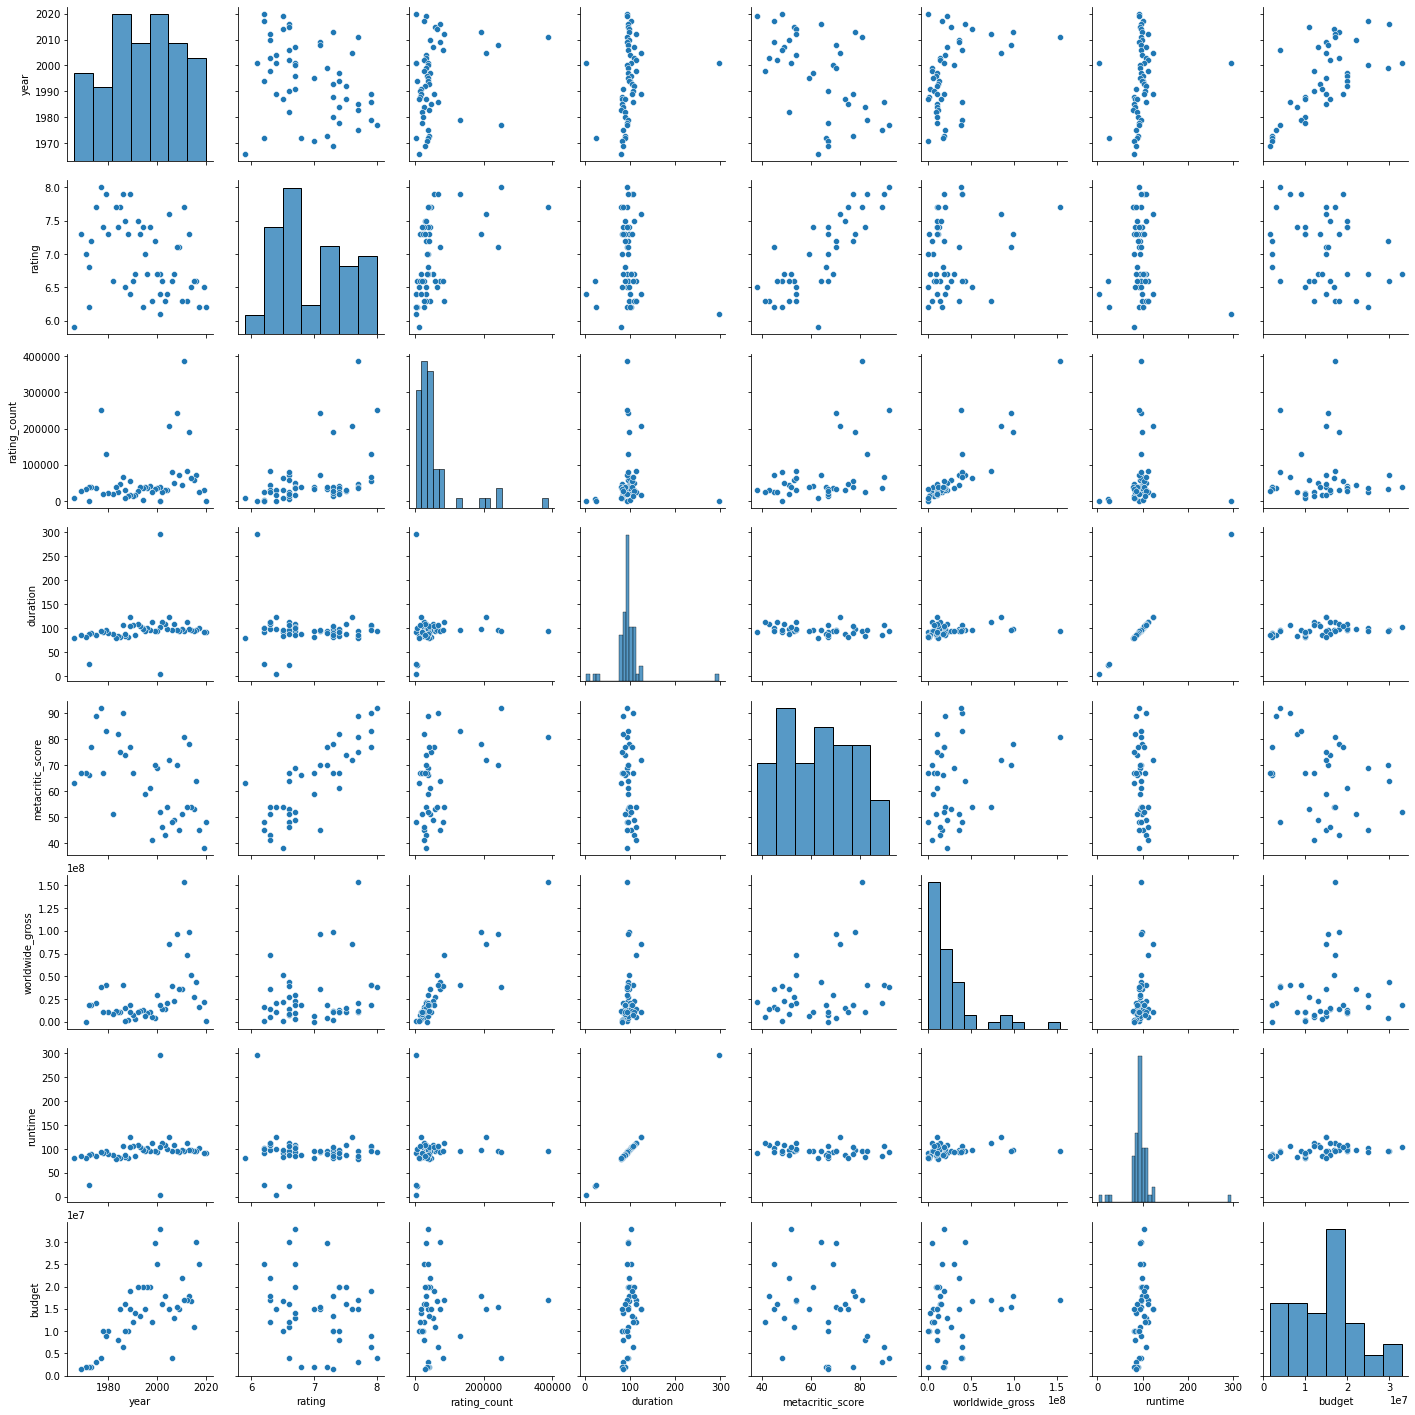

In [95]:
sns.pairplot( film_catalog )

In [ ]:
def traverse(soup):
    found = False
    if soup.name is not None:
        dom_dictionary = {}
        dom_dictionary['name'] = soup.name
        if dom_dictionary['name'] == 'h1':
            print('\n')
            print(soup.text)
            print('\n')
            if not found:
                found_object = soup
                found = True
        dom_dictionary['children'] = [ traverse(child) for child in soup.children if child.name is not None]
        return dom_dictionary, found_object

#traverse(soup)

### Test one film at a time

In [ ]:
#%%script false
# # Test area
# film_url='https://www.imdb.com/title/tt0086153/'
film_url = 'https://www.imdb.com/title/tt0084654/'

film_response = requests.get(film_url)
if(film_response.status_code < 400):
    film_page = film_response.text
    film_soup = BeautifulSoup(film_page, "lxml")
#   if ( not is_TV_Series( film_soup) ):
    film = parse_film_data( film_soup )
    print(film)
